# Task for today:

- compute the error between Lagrange interpolation for equispaced points (in "approximate Linfty") and a given function when the degree increases
- compute the error between Lagrange interpolation for Chebyshev (in "approximate Linfty") and a given function when the degree increases
- compute the error between Bernstein approximation (in "approximate Linfty") and a given function when the degree increases
- compute the L2 projection and compute the error ("in approximate Linfty") norm and compare with previous results


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import scipy.special

def lagrange(i, q, x):
    return product([(x-qj)/(q[i]-qj) for qj in q if qj != q[i]], axis=0)

def bernstein(i, q, x):
    n = len(q)-1
    return scipy.special.binom(n,i)*(1-x)**(n-i)*x**i

def cheb(n):
    return numpy.polynomial.chebyshev.chebgauss(n)[0]*.5+.5

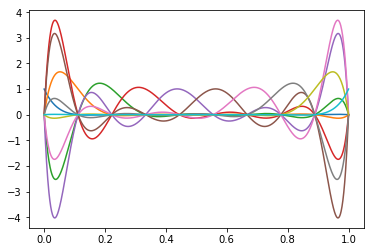

In [5]:
x = linspace(0,1,1025)
q = linspace(0,1,10)
y = array([lagrange(i,q,x) for i in range(len(q))])
_ = plot(x, y.T)

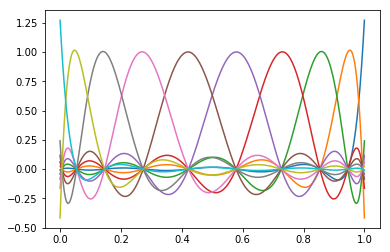

In [6]:
q = cheb(10)
y = array([lagrange(i,q,x) for i in range(len(q))])
_ = plot(x, y.T)

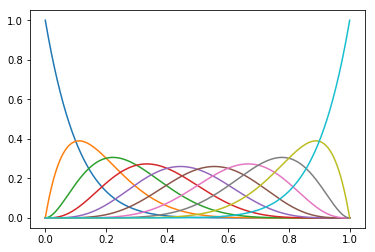

In [7]:
q = linspace(0,1,10)
y = array([bernstein(i,q,x) for i in range(len(q))])
_ = plot(x, y.T)

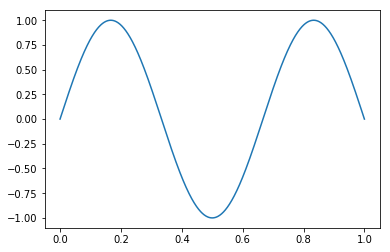

In [8]:
def myfun(x):
    return 1/(1+100*(x-.5)**2)

def myfun(x):
    return sin(3*numpy.pi*x)


plot(x, myfun(x))

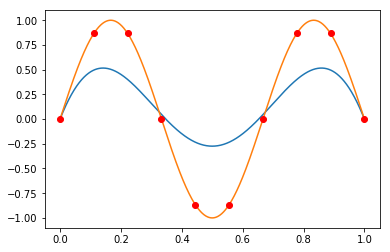

In [9]:
p = y.T.dot(myfun(q))
f = myfun(x)

plot(x,p)
plot(x,f)
plot(q,myfun(q), 'or')

In [10]:
linfty = max(abs(f-p))
linfty

0.72598414958383

In [11]:
def error(q, myfun, interpolation=lagrange) :    
    y = array([interpolation(i,q,x) for i in range(len(q))])
    p = y.T.dot(myfun(q))
    f = myfun(x)
    return (max(abs(f-p)))

In [12]:
N = range(3, 30)
error_equispaced = []
error_cheb = []
error_bernstein = []
for n in N:
    error_cheb.append(error(cheb(n), myfun))
    error_equispaced.append(error(linspace(0,1,n), myfun))
    error_bernstein.append(error(linspace(0,1,n), myfun, bernstein))


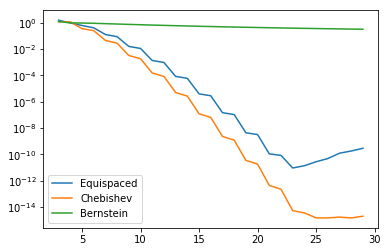

In [13]:
semilogy(N, error_equispaced)
semilogy(N, error_cheb)
semilogy(N, error_bernstein)
_ = legend(['Equispaced','Chebishev','Bernstein'])

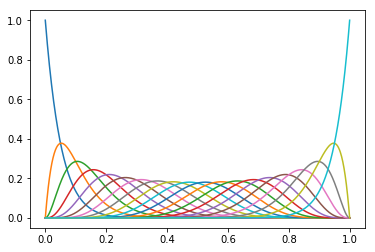

In [14]:
q = linspace(0,1,20)
y = array([bernstein(i,q,x) for i in range(len(q))])
_ = plot(x, y.T)

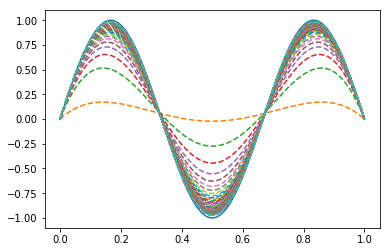

In [15]:
N = range(5,400,5)
plot(x,myfun(x))

for n in N:
    q = linspace(0,1,n)
    y = array([bernstein(i,q,x) for i in range(len(q))])
    p = y.T.dot(myfun(q))
    _ = plot(x, p, '--')


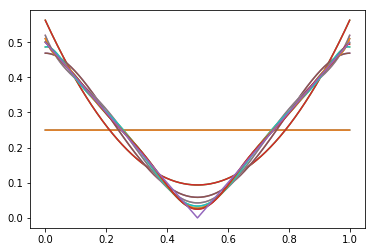

In [16]:
def myfun(x):
    return abs(x-.5)

import scipy
from scipy.integrate import quad as integrate

N = range(1,15)

for n in N:
    M = zeros((n,n))

    for i in range(n):
        for j in range(n):
            M[i,j] = 1.0/(i+j+1)

    F = array([integrate(lambda x: myfun(x)*x**i, 0,1)[0] for i in range(n)])
    pi = linalg.solve(M, F)
    p = sum([x**i*pi[i] for i in range(n)], axis=0)
    plot(x,p)
plot(x,myfun(x))

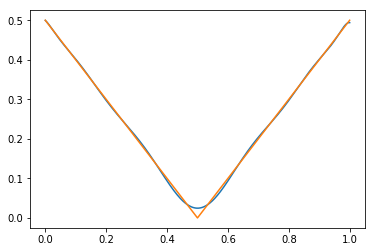

In [17]:
plot(x,p)
plot(x,myfun(x))

In [18]:
max(abs(p-myfun(x)))

0.02462443416821003

Why do we get these errors in the L2 projection? The matrix M is not well conditioned...

In [19]:
linalg.cond(M)

6.200786263161444e+17

Let's turn to numerical quadrature, and Legendre polynomials (for which M is the identity by construction...)

In [20]:
from numpy.polynomial.legendre import leggauss
from numpy.polynomial.legendre import legval
from numpy.polynomial.legendre import Legendre

In [21]:
# We want to compute the polinomial projection of order 10 using the Legendre-Gauss quadrature formula.
# Gives accurate results for functions of order 2n - 1
n = 10
N = n+5


q,w = leggauss(N)
# Moving everything in the interval 0,1 instead of [-1, 1]
w *= .5
q +=1
q /=2

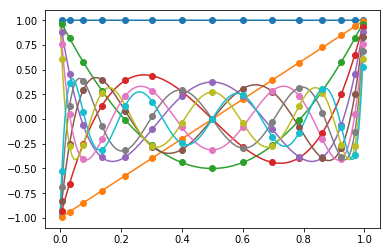

In [22]:
# Vectorizing to perform fast operations thanks to BLAS
v = array([Legendre.basis(i, domain=[0,1])(x) for i in range(n)]) # size n times x
vq = array([Legendre.basis(i, domain=[0,1])(q) for i in range(n)]) # size n times q (number of q. points, 10 here)
_ = plot(x,v.T)
_ = plot(q, vq.T, 'o')

Check that we get a diagonal matrix as M:

In [23]:
# Avoid using the same dimension for x and y to see when we need to transpose.
vq.shape, v.shape

((10, 15), (10, 1025))

In [24]:
# Sum of the i-th basis function evaluated at m-th quadrature point (equal to vq[i, m]) times 
# j-th basis function evaluated at m-th quadrature point (equal to vq[j, m]) times the weights of m, from m = 0 to n_q - 1
M = einsum('im, jm, m', vq, vq, w)

In [25]:
diag = array([M[i,i] for i in range(n)])

In [26]:
diag

array([1.        , 0.33333333, 0.2       , 0.14285714, 0.11111111,
       0.09090909, 0.07692308, 0.06666667, 0.05882353, 0.05263158])

In [34]:
# We remove all the values which are too small, setting them to 0
# We use 1e-14 since we are making errors with a machine precision of 1e-15 and multiplying them for ten times.
# If we had 1000 quadrature points instead of 10, 1e-12 should be the chosen precision, since we could start seeing garbage
# starting from 1e-13.

# If we increase the number of quadrature points too much, results are going to be much worse than those which could be
# obtained by using a smaller number of points, propagating less error.
M2 = M * (abs(M)>1e-14)
M2

array([[ 1.        ,  0.        ,  0.        , -0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.        ],
       [ 0.        ,  0.33333333,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.2       ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.14285714,  0.        ,
         0.        , -0.        ,  0.        , -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.11111111,
        -0.        ,  0.        , -0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.09090909, -0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.07692308,  0.        

Now perform the integral

In [27]:
# Pi is the integral between a and b of v_i(t) times f(t) dt, which can also be expressed in this way.
pi = sum(vq*myfun(q)*w, axis=1)

And plot the function, and its interpolation

In [35]:
# p is the polynomial approximation which solves the problem Mp = F.
# Same as multiplying the inverse of matrix M by pi (10 coefficients) and multiplying them with the function 
p = (pi/diag).dot(v)

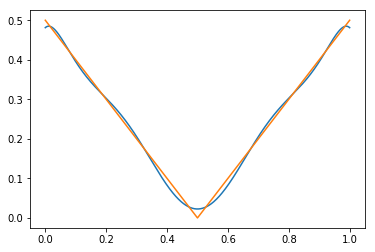

In [29]:
plot(x, p)
_ = plot(x, myfun(x))

In [51]:
# We should compute the Bernstein polynomial basis evaluated at quadrature points. The final result should be the same
# since the L2 distance used to find the optimal approximation is unique.

basis1 = lambda i,q: Legendre.basis(i, domain=[0,1])(q)
basis2 = lambda i,x: bernstein(i, linspace(0,1,n), x)

def l2_projection(n, myfun, basis):
    N = n+5
    q,w = leggauss(N)
    w *= .5
    q +=1
    q /=2
    vq = array([basis(i, q) for i in range(n)])
    M = einsum('im, jm, m', vq, vq, w)
    F = einsum('im, m, m -> i', vq, myfun(q), w)
    # same as F = sum(vq*myfun(q)*w, axis=1)
    p = linalg.solve(M,F)
    return p

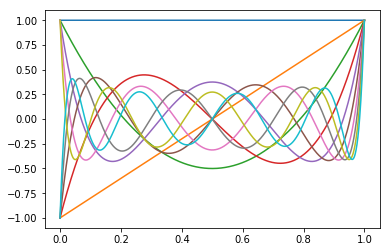

In [54]:
n = 10
#v1 = array([basis1(i, x) for i in range(n)])
v2 = array([basis2(i, x) for i in range(n)])

#p1 = l2_projection(n, myfun, basis1)
p2 = l2_projection(n, myfun, basis2)
#plot(x, v1.T)
plot(x, v2.T)

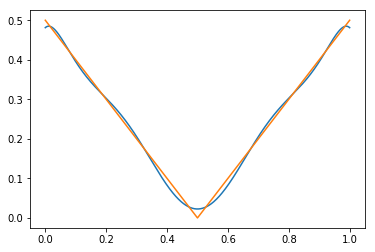

In [55]:
#p = p1.dot(v1)
p = p2.dot(v2)
plot(x, p)
plot(x, myfun(x))